# Chess Dataset Processing and Analysis

This notebook performs detailed analysis on the chess games dataset processed from PGN files. It includes:

1. Loading all CSV files from the processed directory
2. Data cleaning and preparation
3. Detailed exploratory data analysis with visualizations
4. Statistical insights about players, games, openings, and ratings

## 1. Setup and Configuration

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from pathlib import Path
from datetime import datetime
import glob
from tqdm.notebook import tqdm

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')

# Increase pandas display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Define directories
BASE_DIR = Path.cwd().resolve().parents[1]  # Adjust if needed
DATA_DIR = BASE_DIR / "data"
OUTPUT_DIR = DATA_DIR / "processed" / "lumbrasgigabase"
INDIVIDUAL_DIR = OUTPUT_DIR / "individual"
ANALYSIS_DIR = BASE_DIR / "results" / "analysis"

# Create analysis directory if it doesn't exist
ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Individual CSV files directory: {INDIVIDUAL_DIR}")
print(f"Analysis output directory: {ANALYSIS_DIR}")

Base directory: /Users/samir/Desktop/Uppsala/Thesis/thesis_chess_code
Individual CSV files directory: /Users/samir/Desktop/Uppsala/Thesis/thesis_chess_code/data/processed/lumbrasgigabase/individual
Analysis output directory: /Users/samir/Desktop/Uppsala/Thesis/thesis_chess_code/results/analysis


## 2. Load and Prepare Data

Here we'll find and load all CSV files containing the processed chess games.

In [2]:
# Find all CSV files
csv_files = list(INDIVIDUAL_DIR.glob('*.csv'))
print(f"Found {len(csv_files)} CSV files:")
for file in csv_files:
    print(f"  - {file.name}")

Found 14 CSV files:
  - lumbrasgigabase_2024.csv
  - lumbrasgigabase_1970-1989.csv
  - lumbrasgigabase_2021.csv
  - lumbrasgigabase_2020.csv
  - lumbrasgigabase_2022.csv
  - lumbrasgigabase_2023.csv
  - lumbrasgigabase_1900-1949.csv
  - lumbrasgigabase_1950-1969.csv
  - lumbrasgigabase_2010-2014.csv
  - lumbrasgigabase_2015-2019.csv
  - lumbrasgigabase_1990-1999.csv
  - lumbrasgigabase_2005-2009.csv
  - lumbrasgigabase_2000-2004.csv
  - lumbrasgigabase_1899.csv


In [3]:
# Load and combine all CSV files
def load_csvs(csv_files):
    dataframes = []
    file_counts = {}
    
    for file in tqdm(csv_files, desc="Loading CSV files"):
        try:
            df = pd.read_csv(file, low_memory=False)
            file_counts[file.name] = len(df)
            dataframes.append(df)
        except Exception as e:
            print(f"Error loading {file.name}: {e}")
    
    # Combine all dataframes
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    return combined_df, file_counts

# Load and combine all CSV files
chess_df, file_counts = load_csvs(csv_files)

# Display file counts
print("\nRows per file:")
for file, count in file_counts.items():
    print(f"  - {file}: {count:,} rows")

print(f"\nTotal rows in combined dataset: {len(chess_df):,}")

Loading CSV files:   0%|          | 0/14 [00:00<?, ?it/s]


Rows per file:
  - lumbrasgigabase_2024.csv: 1,970,228 rows
  - lumbrasgigabase_1970-1989.csv: 548,257 rows
  - lumbrasgigabase_2021.csv: 1,775,011 rows
  - lumbrasgigabase_2020.csv: 648,622 rows
  - lumbrasgigabase_2022.csv: 1,705,688 rows
  - lumbrasgigabase_2023.csv: 1,584,334 rows
  - lumbrasgigabase_1900-1949.csv: 79,251 rows
  - lumbrasgigabase_1950-1969.csv: 165,369 rows
  - lumbrasgigabase_2010-2014.csv: 1,398,876 rows
  - lumbrasgigabase_2015-2019.csv: 1,491,380 rows
  - lumbrasgigabase_1990-1999.csv: 1,382,020 rows
  - lumbrasgigabase_2005-2009.csv: 1,225,641 rows
  - lumbrasgigabase_2000-2004.csv: 992,016 rows
  - lumbrasgigabase_1899.csv: 16,430 rows

Total rows in combined dataset: 14,983,123


### Data Preview and Initial Analysis

In [4]:
# Show the first few rows
chess_df.head()

,event,site,date,round,white,black,result,white_elo,black_elo,white_title,black_title,eco,opening,time_control,import_date,source,moves,eval_info,clock_info
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LumbrasGigaBase,NaN,NaN,NaN
1,Titled Tue 23. Jul Early,chess.com INT,2024.07.23,10,"Adam, Ernestina","Jimenez Jimenez, Leandro",1-0,2055.0,2161.0,WFM,FM,B12j,NaN,NaN,2024-08-06,LumbrasGigaBase,1.e4 c6 2.d4 d5 3.e5 c5 4.dxc5 e6 5.a3 Bxc5 6.Qg4 Kf8 7.b4 Bb6 8.Nf3 Nd7 9.Bd3 Ne7 10.O-O Qc7 11...,NaN,NaN
2,Liga Nacional Superior,Villa Martelli ARG,2024.09.15,4.3,"Adam, Ernestina","Tempone, Marcelo",1/2-1/2,2060.0,2373.0,WFM,IM,B12m,Caro-Kann,NaN,2024-11-05,LumbrasGigaBase,1.e4 c6 2.d4 d5 3.e5 Bf5 4.h4 Qb6 5.a4 h5 6.a5 Qc7 7.c3 e6 8.Nf3 Nd7 9.Be2 Ne7 10.O-O Ng6 11.Re1...,NaN,NaN
3,Titled Tue 23. Jul Early,chess.com INT,2024.07.23,6,"Adam, Ernestina","Vaglio Mattey, Emanuel",0-1,2055.0,2155.0,WFM,CM,B12m,NaN,NaN,2024-08-06,LumbrasGigaBase,1.e4 c6 2.d4 d5 3.e5 Bf5 4.h4 h5 5.Bd3 Bxd3 6.Qxd3 e6 7.Bg5 Qa5+ 8.Nd2 Ne7 9.Ne2 Nf5 10.Ng3 Nxg3...,NaN,NaN
4,Titled Tue 14. May Early,chess.com INT,2024.05.14,4,"Adam, Ernestina","Victor, Julian",0-1,1998.0,2298.0,WFM,FM,B12m,NaN,NaN,2024-05-21,LumbrasGigaBase,1.e4 c6 2.d4 d5 3.e5 Bf5 4.h4 Qc7 5.Bd3 Bxd3 6.Qxd3 e6 7.Ne2 c5 8.c3 Nc6 9.a3 c4 10.Qg3 Nge7 11....,NaN,NaN


In [5]:
# Get basic information about the dataset
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14983123 entries, 0 to 14983122
Data columns (total 19 columns):
 #   Column        Dtype  
---  ------        -----  
 0   event         object 
 1   site          object 
 2   date          object 
 3   round         object 
 4   white         object 
 5   black         object 
 6   result        object 
 7   white_elo     float64
 8   black_elo     float64
 9   white_title   object 
 10  black_title   object 
 11  eco           object 
 12  opening       object 
 13  time_control  object 
 14  import_date   object 
 15  source        object 
 16  moves         object 
 17  eval_info     object 
 18  clock_info    object 
dtypes: float64(2), object(17)
memory usage: 2.1+ GB


In [6]:
# Check for missing values
missing_values = chess_df.isnull().sum()
missing_percentage = missing_values / len(chess_df) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
}).sort_values('Missing Values', ascending=False)

missing_df[missing_df['Missing Values'] > 0]

,Missing Values,Percentage
eval_info,14937669,99.696632
clock_info,14823342,98.933593
opening,14695391,98.079626
import_date,13058523,87.154881
black_title,12728173,84.950067
white_title,12725570,84.932694
time_control,10471523,69.888788
site,6240924,41.653025
event,3770772,25.166796
round,2279382,15.212997


In [7]:
# Convert specific columns to appropriate data types
# Convert Elo ratings to numeric
chess_df['white_elo'] = pd.to_numeric(chess_df['white_elo'], errors='coerce')
chess_df['black_elo'] = pd.to_numeric(chess_df['black_elo'], errors='coerce')

# Parse dates (if they're in a standard format)
try:
    chess_df['date'] = pd.to_datetime(chess_df['date'], errors='coerce')
except:
    print("Could not convert date column to datetime. Keeping as string.")

# Calculate additional features
chess_df['avg_elo'] = (chess_df['white_elo'] + chess_df['black_elo']) / 2
chess_df['elo_difference'] = chess_df['white_elo'] - chess_df['black_elo']

# Count moves in each game
chess_df['move_count'] = chess_df['moves'].fillna('').apply(lambda x: len(re.findall(r'\d+\.', x)))

# Basic result mapping
result_mapping = {
    '1-0': 'White Win',
    '0-1': 'Black Win',
    '1/2-1/2': 'Draw',
    '*': 'Unknown'
}
chess_df['result_category'] = chess_df['result'].map(result_mapping)

# Check if eval_info and clock_info contains data
chess_df['has_eval_info'] = chess_df['eval_info'].notna()
chess_df['has_clock_info'] = chess_df['clock_info'].notna()

# Show updated info
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14983123 entries, 0 to 14983122
Data columns (total 25 columns):
 #   Column           Dtype         
---  ------           -----         
 0   event            object        
 1   site             object        
 2   date             datetime64[ns]
 3   round            object        
 4   white            object        
 5   black            object        
 6   result           object        
 7   white_elo        float64       
 8   black_elo        float64       
 9   white_title      object        
 10  black_title      object        
 11  eco              object        
 12  opening          object        
 13  time_control     object        
 14  import_date      object        
 15  source           object        
 16  moves            object        
 17  eval_info        object        
 18  clock_info       object        
 19  avg_elo          float64       
 20  elo_difference   float64       
 21  move_count       int64       

## 3. Data Cleaning

Remove records where white, black, white_elo, black_elo, eco, or moves are NULL.

In [8]:
# Count before cleaning
before_count = len(chess_df)
print(f"Number of records before cleaning: {before_count:,}")

# Store individual missing counts for each field before cleaning
fields_to_check = ['white', 'black', 'white_elo', 'black_elo', 'eco', 'moves']
missing_before = {field: chess_df[field].isna().sum() for field in fields_to_check}

for field, count in missing_before.items():
    print(f"  - Missing {field}: {count:,} ({count/before_count*100:.2f}%)")

Number of records before cleaning: 14,983,123
  - Missing white: 10,678 (0.07%)
  - Missing black: 10,682 (0.07%)
  - Missing white_elo: 1,572,260 (10.49%)
  - Missing black_elo: 1,587,955 (10.60%)
  - Missing eco: 10,567 (0.07%)
  - Missing moves: 7,056 (0.05%)


In [9]:
# Clean the data by removing rows with NULL values in specific fields
chess_df_clean = chess_df.dropna(subset=['white', 'black', 'white_elo', 'black_elo', 'eco', 'moves'])

# Count after cleaning
after_count = len(chess_df_clean)
print(f"Number of records after cleaning: {after_count:,}")
print(f"Removed {before_count - after_count:,} records ({(before_count - after_count)/before_count*100:.2f}%)")

Number of records after cleaning: 12,917,479
Removed 2,065,644 records (13.79%)


In [10]:
# Store the clean dataset to a new file for future use
clean_data_path = ANALYSIS_DIR / "chess_games_clean.csv"
chess_df_clean.to_csv(clean_data_path, index=False)
print(f"Saved clean dataset to {clean_data_path}")

Saved clean dataset to /Users/samir/Desktop/Uppsala/Thesis/thesis_chess_code/results/analysis/chess_games_clean.csv


## 4. Exploratory Data Analysis

Now let's analyze the clean dataset with visualizations and statistics.

### 4.1 Basic Statistics

In [11]:
# Basic statistics of numerical columns
chess_df_clean.describe()

,date,white_elo,black_elo,avg_elo,elo_difference,move_count
count,12069342,1.291748e+07,1.291748e+07,1.291748e+07,1.291748e+07,1.291748e+07
mean,2018-05-15 16:25:52.994023680,2.404234e+03,2.402450e+03,2.403342e+03,1.783740e+00,4.384206e+01
min,1959-07-24 00:00:00,1.000000e+00,1.000000e+00,9.030000e+02,-2.339000e+03,0.000000e+00
25%,2014-12-01 00:00:00,2.218000e+03,2.215000e+03,2.216500e+03,-9.800000e+01,3.000000e+01
50%,2021-08-21 00:00:00,2.466000e+03,2.465000e+03,2.459500e+03,1.000000e+00,4.000000e+01
75%,2023-05-02 00:00:00,2.613000e+03,2.612000e+03,2.613000e+03,1.010000e+02,5.400000e+01
max,2024-12-31 00:00:00,3.693000e+03,3.697000e+03,3.592500e+03,2.400000e+03,8.660000e+02
std,NaN,2.891879e+02,2.903525e+02,2.748081e+02,1.838215e+02,2.254595e+01


In [12]:
# Game results distribution
result_counts = chess_df_clean['result_category'].value_counts()
print("Game Results Distribution:")
print(result_counts)
print(f"\nWhite win percentage: {result_counts.get('White Win', 0) / len(chess_df_clean) * 100:.2f}%")
print(f"Black win percentage: {result_counts.get('Black Win', 0) / len(chess_df_clean) * 100:.2f}%")
print(f"Draw percentage: {result_counts.get('Draw', 0) / len(chess_df_clean) * 100:.2f}%")

Game Results Distribution:
result_category
White Win    5419784
Black Win    4596827
Draw         2900868
Name: count, dtype: int64

White win percentage: 41.96%
Black win percentage: 35.59%
Draw percentage: 22.46%


### 4.2 Elo Rating Analysis

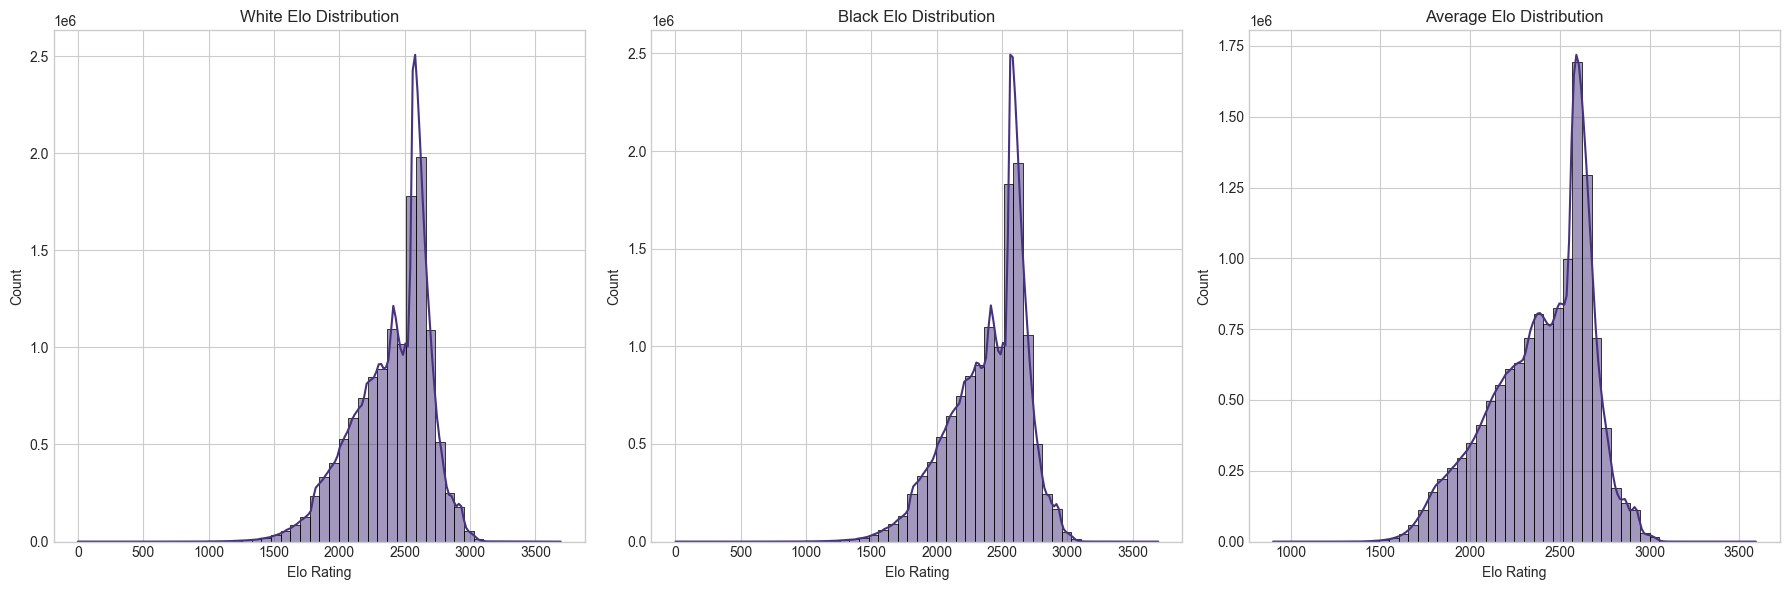

In [13]:
# Create subplots for Elo distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot White Elo distribution
sns.histplot(chess_df_clean['white_elo'].dropna(), kde=True, bins=50, ax=axes[0])
axes[0].set_title('White Elo Distribution')
axes[0].set_xlabel('Elo Rating')

# Plot Black Elo distribution
sns.histplot(chess_df_clean['black_elo'].dropna(), kde=True, bins=50, ax=axes[1])
axes[1].set_title('Black Elo Distribution')
axes[1].set_xlabel('Elo Rating')

# Plot Average Elo distribution
sns.histplot(chess_df_clean['avg_elo'].dropna(), kde=True, bins=50, ax=axes[2])
axes[2].set_title('Average Elo Distribution')
axes[2].set_xlabel('Elo Rating')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'elo_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

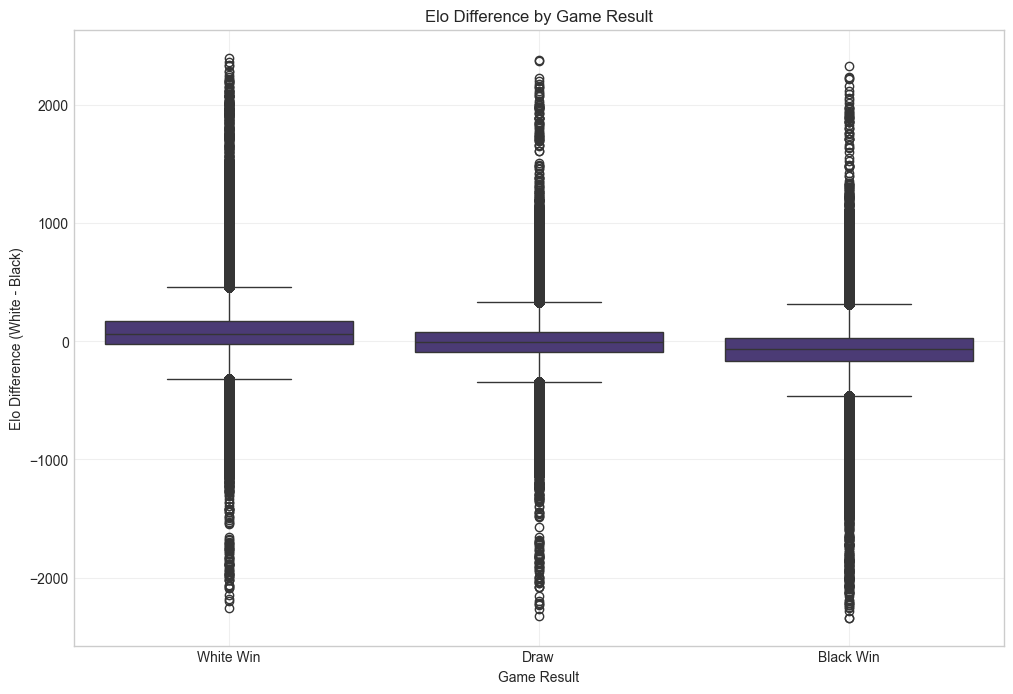

In [14]:
# Elo vs Result
plt.figure(figsize=(12, 8))
sns.boxplot(x='result_category', y='elo_difference', data=chess_df_clean)
plt.title('Elo Difference by Game Result')
plt.xlabel('Game Result')
plt.ylabel('Elo Difference (White - Black)')
plt.grid(True, alpha=0.3)
plt.savefig(ANALYSIS_DIR / 'elo_difference_by_result.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.3 Game Length Analysis

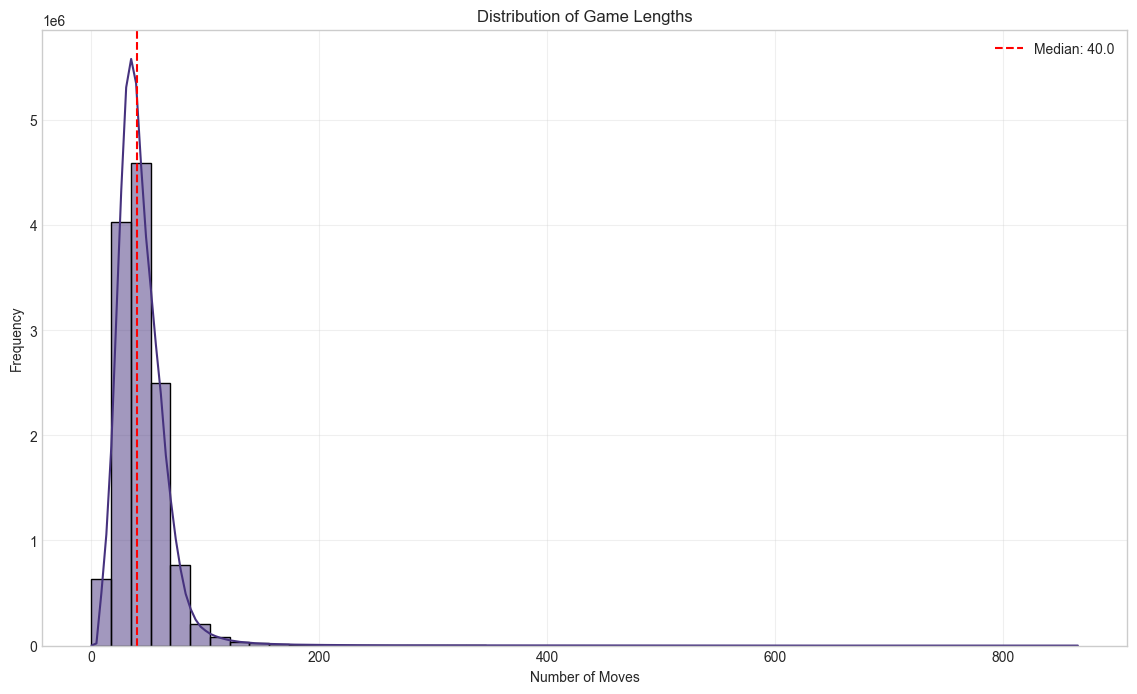

In [15]:
# Game length distribution
plt.figure(figsize=(14, 8))
sns.histplot(chess_df_clean['move_count'].dropna(), kde=True, bins=50)
plt.title('Distribution of Game Lengths')
plt.xlabel('Number of Moves')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.axvline(chess_df_clean['move_count'].median(), color='red', linestyle='--', 
            label=f'Median: {chess_df_clean["move_count"].median():.1f}')
plt.legend()
plt.savefig(ANALYSIS_DIR / 'game_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

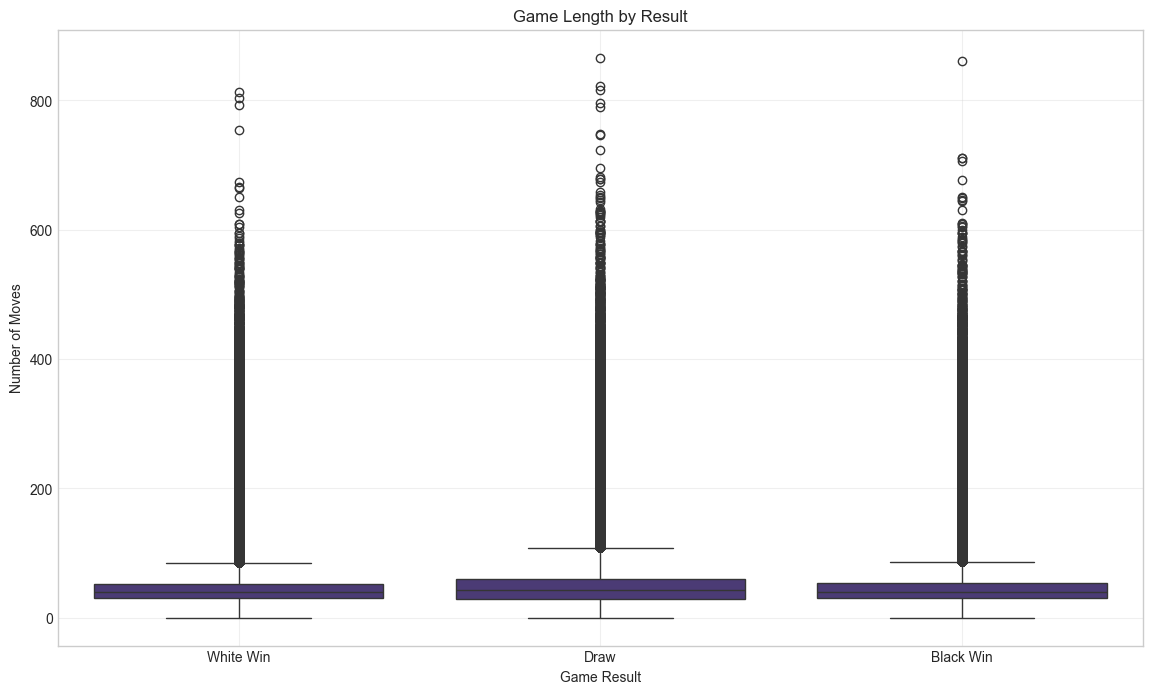

In [16]:
# Game length by result
plt.figure(figsize=(14, 8))
sns.boxplot(x='result_category', y='move_count', data=chess_df_clean)
plt.title('Game Length by Result')
plt.xlabel('Game Result')
plt.ylabel('Number of Moves')
plt.grid(True, alpha=0.3)
plt.savefig(ANALYSIS_DIR / 'game_length_by_result.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.4 Opening Analysis

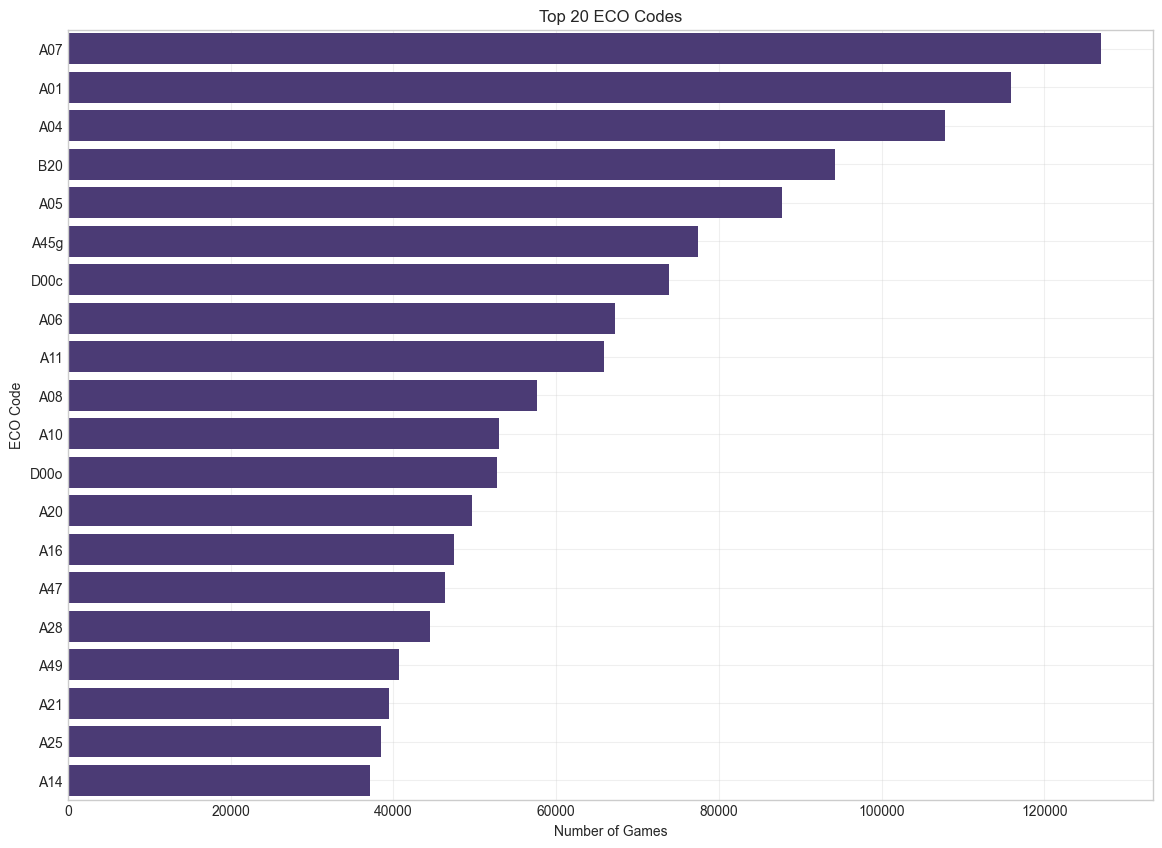

In [17]:
# Top ECO codes
top_eco = chess_df_clean['eco'].value_counts().head(20)
plt.figure(figsize=(14, 10))
sns.barplot(x=top_eco.values, y=top_eco.index)
plt.title('Top 20 ECO Codes')
plt.xlabel('Number of Games')
plt.ylabel('ECO Code')
plt.grid(True, alpha=0.3)
plt.savefig(ANALYSIS_DIR / 'top_eco_codes.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/1r/jcq7c7353hsb6scsnq4g2pp00000gn/T/ipykernel_11599/265065958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_df_clean['eco_family'] = chess_df_clean['eco'].str[0]


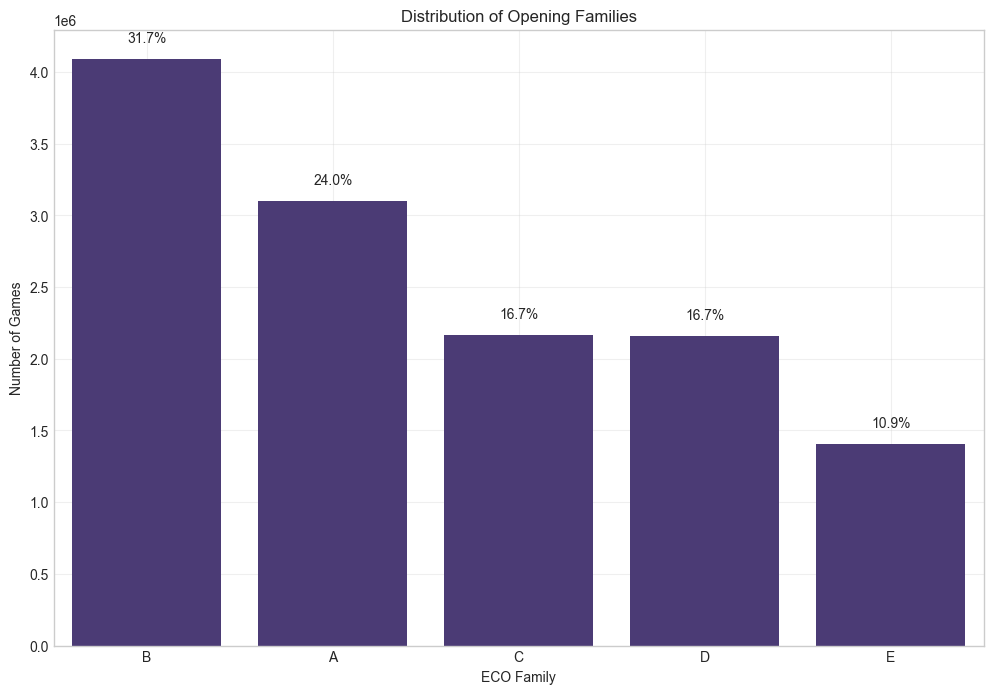

ECO Code Families:
  - A: Flank Openings
  - B: Semi-Open Games (except French)
  - C: Open Games and French
  - D: Closed Games & Semi-Closed
  - E: Indian Defenses


In [18]:
# Extract opening family (first letter of ECO code)
chess_df_clean['eco_family'] = chess_df_clean['eco'].str[0]

# Opening families distribution
eco_family_counts = chess_df_clean['eco_family'].value_counts()
eco_families = {
    'A': 'Flank Openings',
    'B': 'Semi-Open Games (except French)',
    'C': 'Open Games and French',
    'D': 'Closed Games & Semi-Closed',
    'E': 'Indian Defenses'
}

# Create a new Series with family names
eco_family_names = pd.Series(index=eco_family_counts.index, data=[eco_families.get(i, i) for i in eco_family_counts.index])

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=eco_family_counts.index, y=eco_family_counts.values)
plt.title('Distribution of Opening Families')
plt.xlabel('ECO Family')
plt.ylabel('Number of Games')

# Add percentage labels
total = len(chess_df_clean)
for i, p in enumerate(ax.patches):
    percentage = 100 * p.get_height() / total
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom', xytext = (0, 10), 
                textcoords = 'offset points')

plt.grid(True, alpha=0.3)
plt.savefig(ANALYSIS_DIR / 'opening_families.png', dpi=300, bbox_inches='tight')
plt.show()

# Print family descriptions
print("ECO Code Families:")
for code, desc in eco_families.items():
    print(f"  - {code}: {desc}")

<Figure size 1400x800 with 0 Axes>

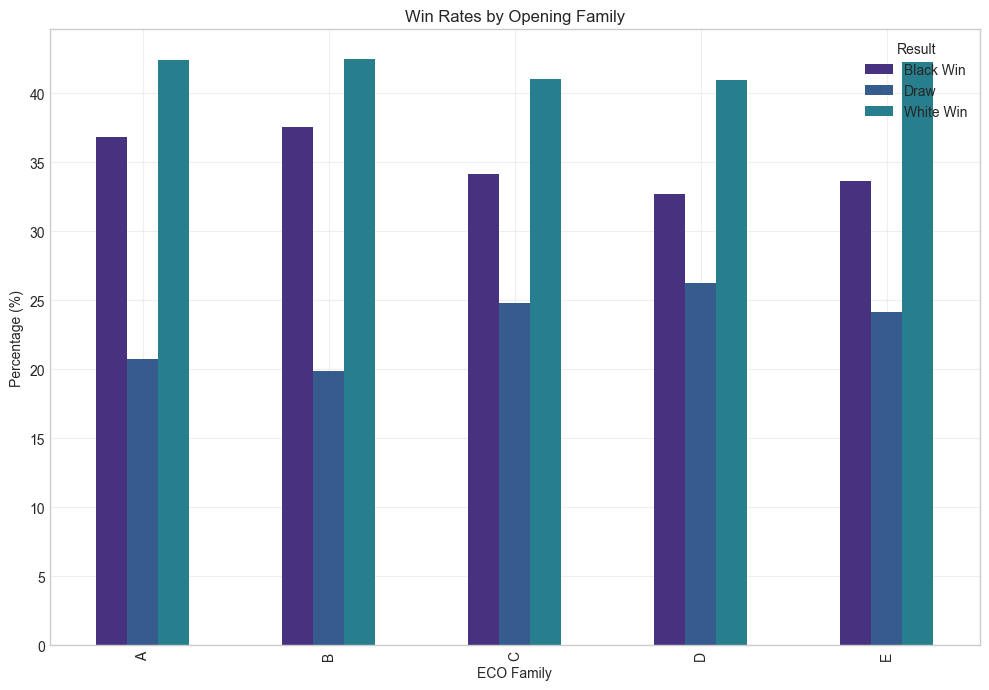

In [19]:
# Win rates by opening family
opening_results = chess_df_clean.groupby('eco_family')['result_category'].value_counts(normalize=True).unstack()
opening_results = opening_results.fillna(0) * 100  # Convert to percentages

plt.figure(figsize=(14, 8))
opening_results.plot(kind='bar', stacked=False)
plt.title('Win Rates by Opening Family')
plt.xlabel('ECO Family')
plt.ylabel('Percentage (%)')
plt.grid(True, alpha=0.3)
plt.legend(title='Result')
plt.savefig(ANALYSIS_DIR / 'win_rates_by_opening.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.5 Player Analysis

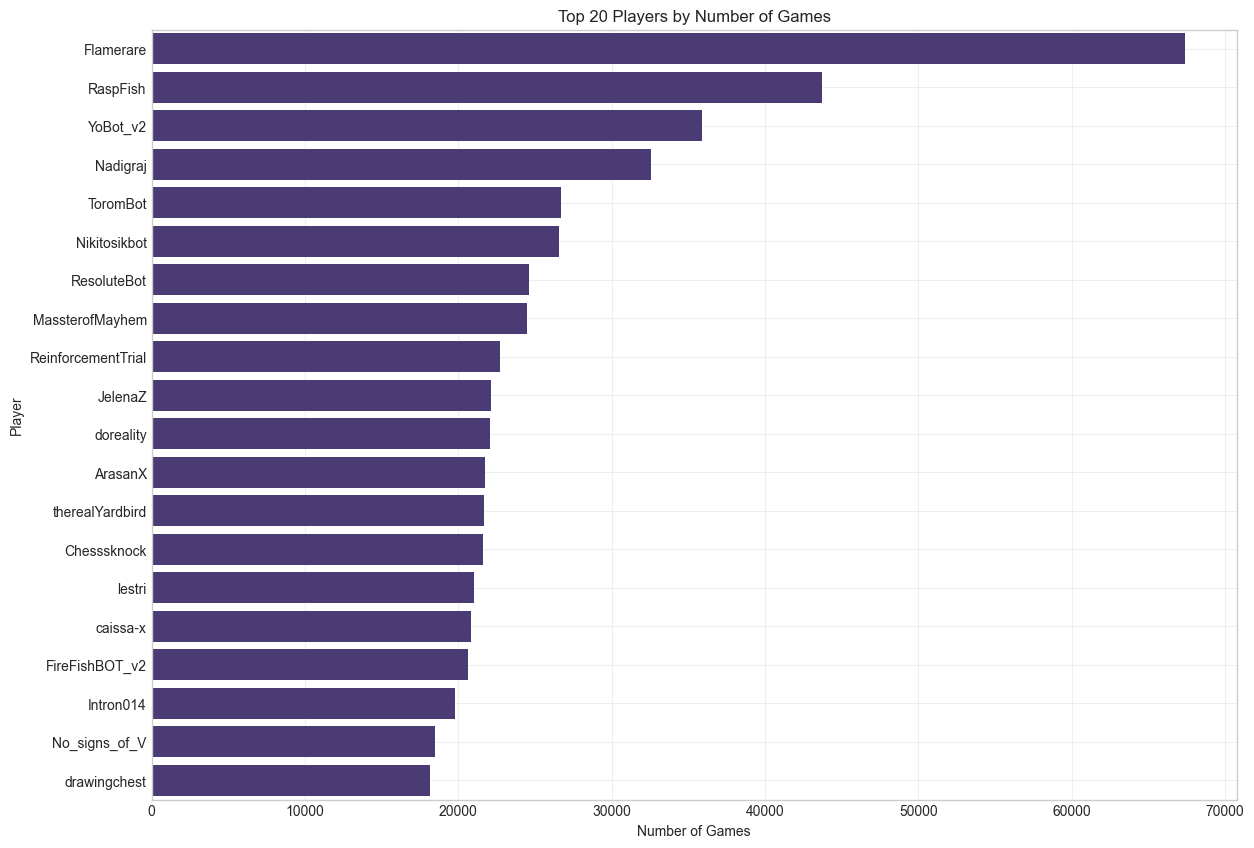

In [20]:
# Count games by player (white and black combined)
white_counts = chess_df_clean['white'].value_counts()
black_counts = chess_df_clean['black'].value_counts()

# Combine the counts
player_counts = white_counts.add(black_counts, fill_value=0).sort_values(ascending=False)

# Display top players by number of games
top_players = player_counts.head(20)
plt.figure(figsize=(14, 10))
sns.barplot(x=top_players.values, y=top_players.index)
plt.title('Top 20 Players by Number of Games')
plt.xlabel('Number of Games')
plt.ylabel('Player')
plt.grid(True, alpha=0.3)
plt.savefig(ANALYSIS_DIR / 'top_players.png', dpi=300, bbox_inches='tight')
plt.show()

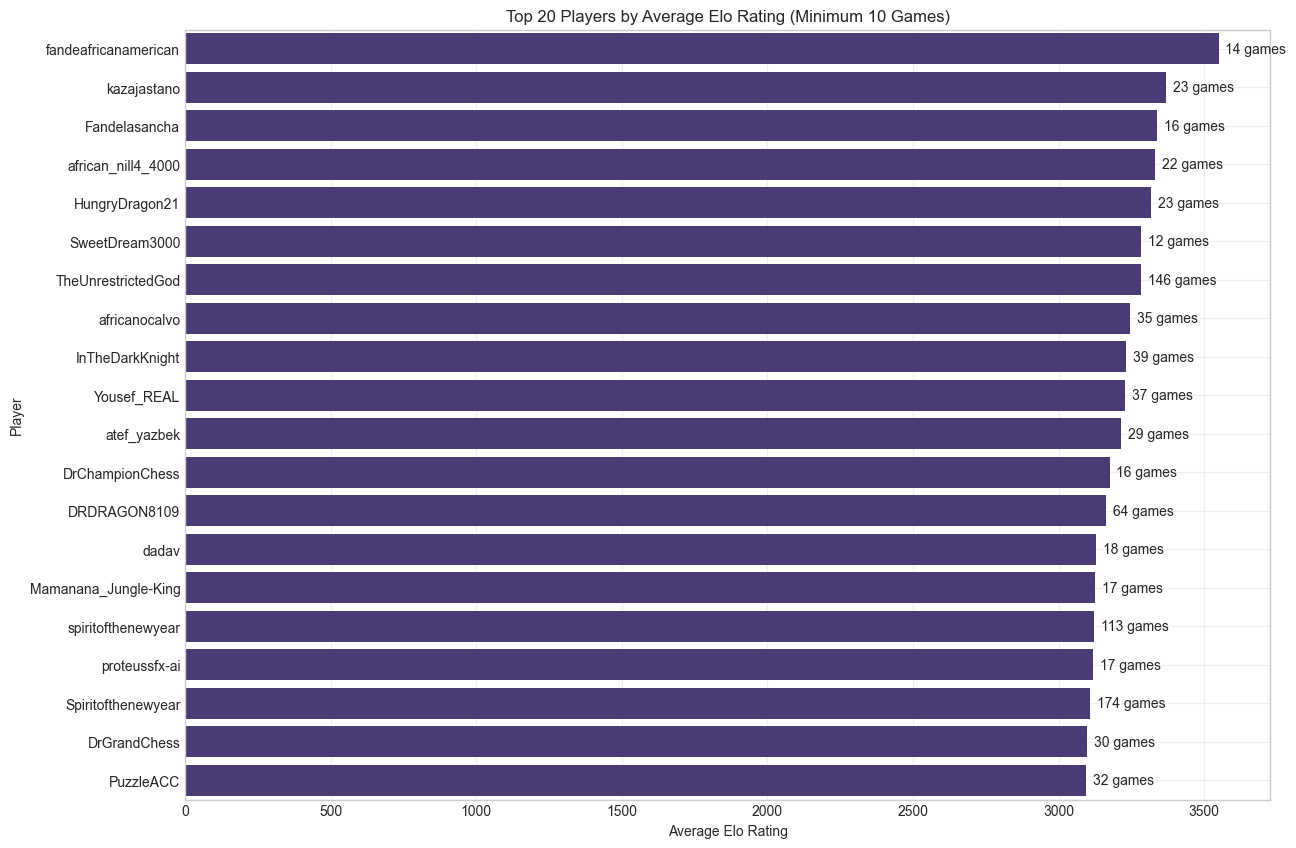

In [21]:
# Players with highest average Elo (minimum 10 games)
player_white = chess_df_clean.groupby('white')['white_elo'].agg(['mean', 'count'])
player_black = chess_df_clean.groupby('black')['black_elo'].agg(['mean', 'count'])

# Combine white and black games
player_combined = pd.DataFrame({
    'white_elo': player_white['mean'],
    'white_count': player_white['count'],
    'black_elo': player_black['mean'],
    'black_count': player_black['count']
}).fillna(0)

# Calculate weighted average Elo
player_combined['total_games'] = player_combined['white_count'] + player_combined['black_count']
player_combined['avg_elo'] = (player_combined['white_elo'] * player_combined['white_count'] + 
                              player_combined['black_elo'] * player_combined['black_count']) / player_combined['total_games']

# Filter for players with at least 10 games
player_filtered = player_combined[player_combined['total_games'] >= 10]

# Display top players by Elo
top_elo_players = player_filtered.sort_values('avg_elo', ascending=False).head(20)
plt.figure(figsize=(14, 10))
ax = sns.barplot(x=top_elo_players['avg_elo'], y=top_elo_players.index)

# Add game count labels
for i, p in enumerate(ax.patches):
    games = top_elo_players.iloc[i]['total_games']
    ax.annotate(f'{games:.0f} games', 
                (p.get_width(), p.get_y() + p.get_height()/2),
                ha = 'left', va = 'center', xytext = (5, 0), 
                textcoords = 'offset points')

plt.title('Top 20 Players by Average Elo Rating (Minimum 10 Games)')
plt.xlabel('Average Elo Rating')
plt.ylabel('Player')
plt.grid(True, alpha=0.3)
plt.savefig(ANALYSIS_DIR / 'top_elo_players.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.6 Time-based Analysis

Analyzing how games have evolved over time.

/var/folders/1r/jcq7c7353hsb6scsnq4g2pp00000gn/T/ipykernel_11599/2998451570.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_df_clean['year'] = chess_df_clean['date'].dt.year


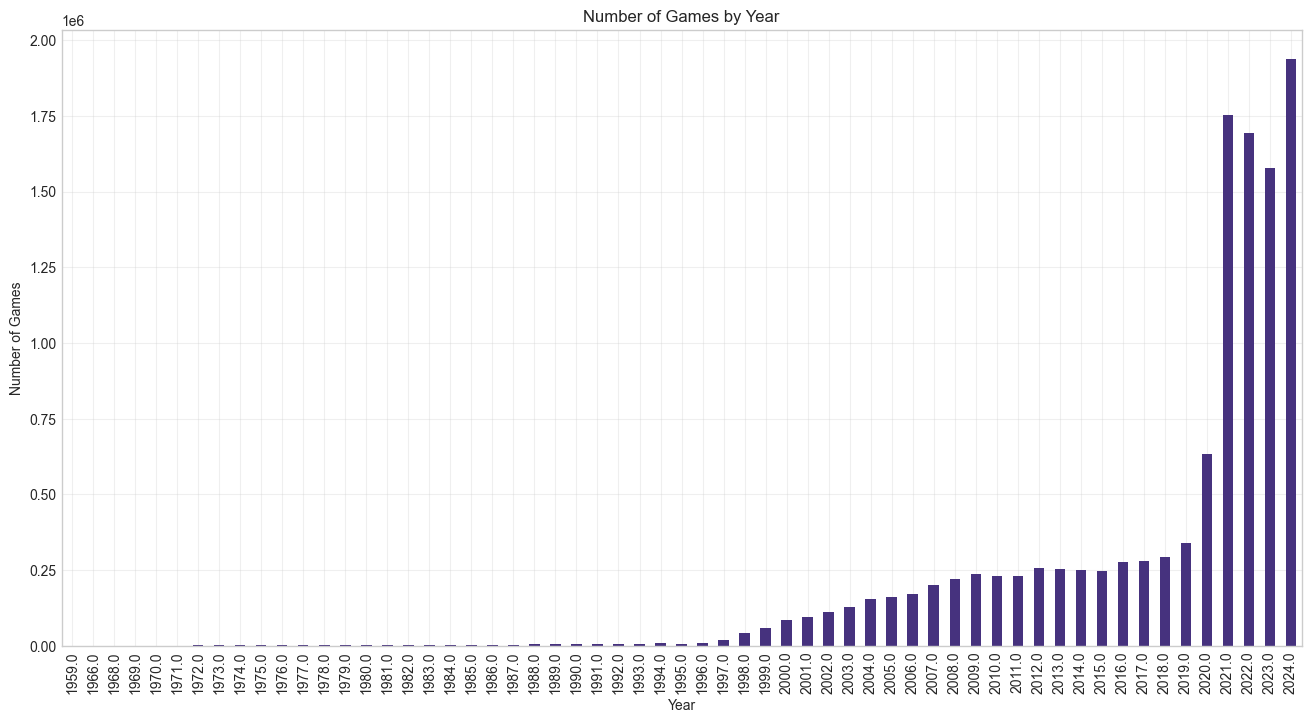

In [22]:
# Extract year from date if possible
if pd.api.types.is_datetime64_dtype(chess_df_clean['date'].dtype):
    chess_df_clean['year'] = chess_df_clean['date'].dt.year
else:
    # Try to extract year from date string (assumes format like "YYYY.MM.DD")
    chess_df_clean['year'] = chess_df_clean['date'].str.extract(r'^(\d{4})').astype(float)

# Filter out extreme years (data quality issues)
year_stats = chess_df_clean['year'].describe()
min_year = max(1800, year_stats['min'])  # Reasonable minimum year
max_year = min(datetime.now().year, year_stats['max'])  # Current year as maximum

# Keep only games with valid years
chess_df_years = chess_df_clean[(chess_df_clean['year'] >= min_year) & 
                                (chess_df_clean['year'] <= max_year)]

# Games by year
yearly_counts = chess_df_years.groupby('year').size()

plt.figure(figsize=(16, 8))
yearly_counts.plot(kind='bar')
plt.title('Number of Games by Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=90)
plt.savefig(ANALYSIS_DIR / 'games_by_year.png', dpi=300, bbox_inches='tight')
plt.show()

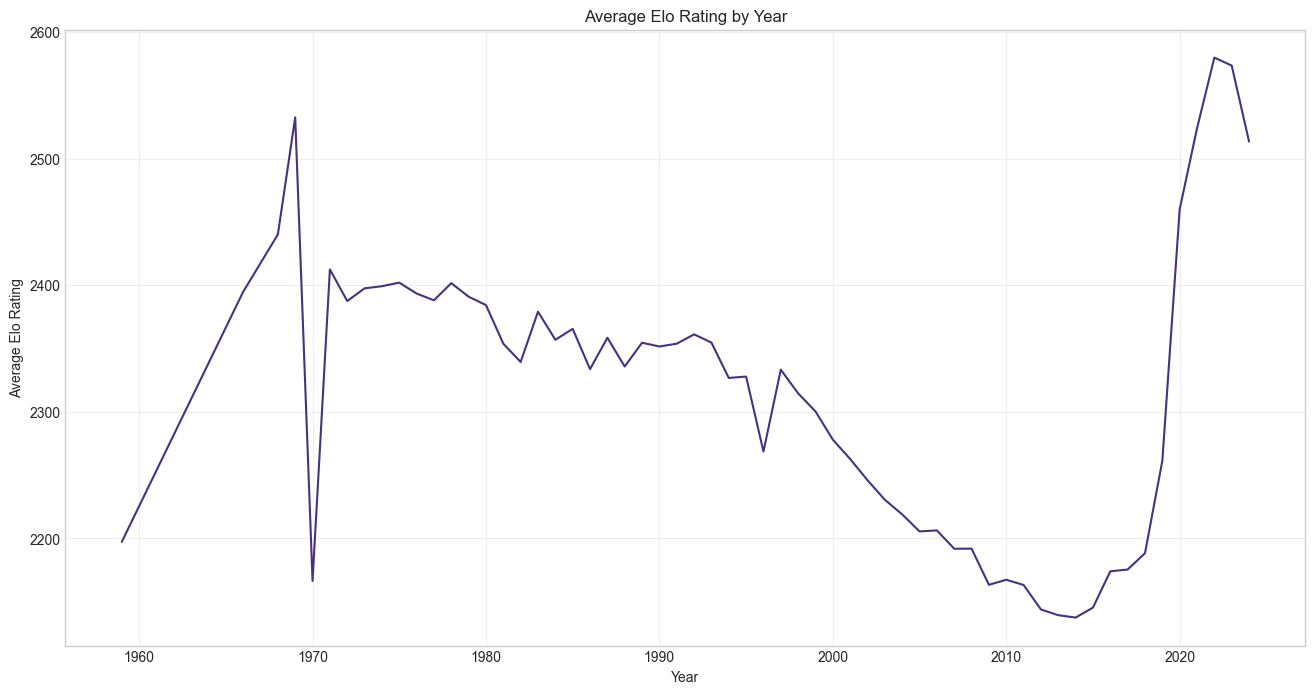

In [23]:
# Average Elo rating by year
yearly_elo = chess_df_years.groupby('year')['avg_elo'].mean()

plt.figure(figsize=(16, 8))
yearly_elo.plot()
plt.title('Average Elo Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Elo Rating')
plt.grid(True, alpha=0.3)
plt.savefig(ANALYSIS_DIR / 'avg_elo_by_year.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1600x800 with 0 Axes>

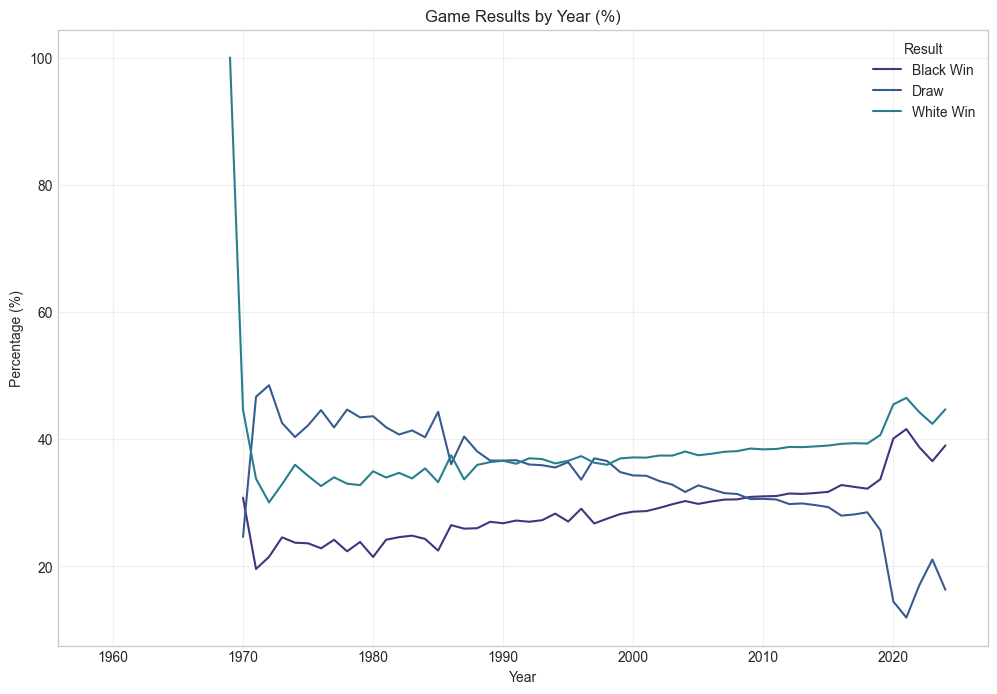

In [24]:
# Game results by year
result_by_year = chess_df_years.groupby(['year', 'result_category']).size().unstack()
result_by_year_pct = result_by_year.div(result_by_year.sum(axis=1), axis=0) * 100

plt.figure(figsize=(16, 8))
result_by_year_pct.plot()
plt.title('Game Results by Year (%)')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.grid(True, alpha=0.3)
plt.legend(title='Result')
plt.savefig(ANALYSIS_DIR / 'results_by_year.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.7 ECO Code and Opening Analysis

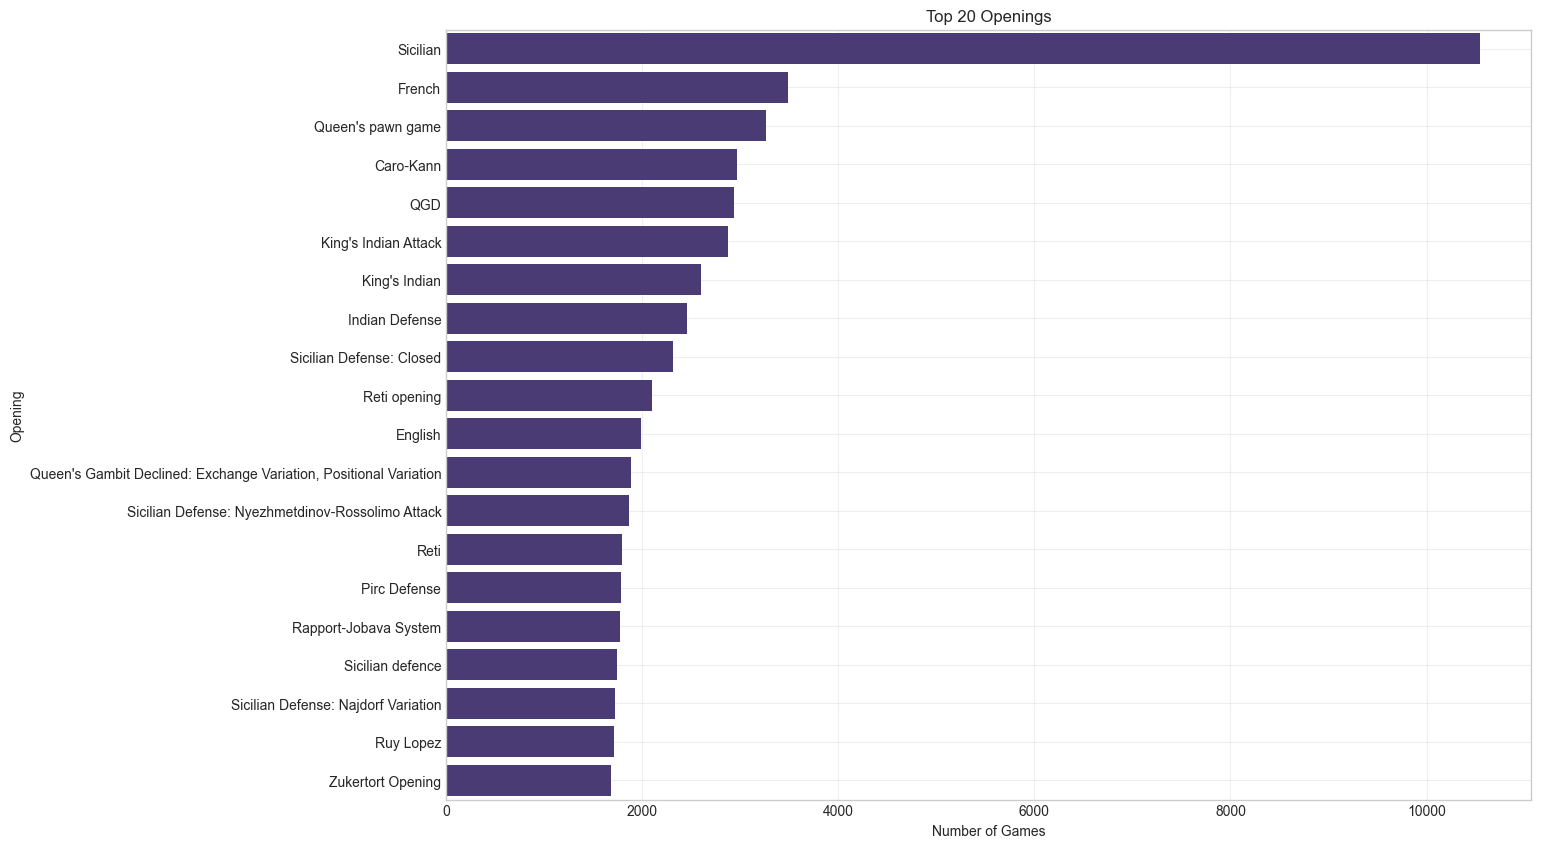

In [25]:
# Top openings (if available)
if 'opening' in chess_df_clean.columns and not chess_df_clean['opening'].isna().all():
    top_openings = chess_df_clean['opening'].value_counts().head(20)
    
    plt.figure(figsize=(14, 10))
    sns.barplot(x=top_openings.values, y=top_openings.index)
    plt.title('Top 20 Openings')
    plt.xlabel('Number of Games')
    plt.ylabel('Opening')
    plt.grid(True, alpha=0.3)
    plt.savefig(ANALYSIS_DIR / 'top_openings.png', dpi=300, bbox_inches='tight')
    plt.show()

<Figure size 1600x1000 with 0 Axes>

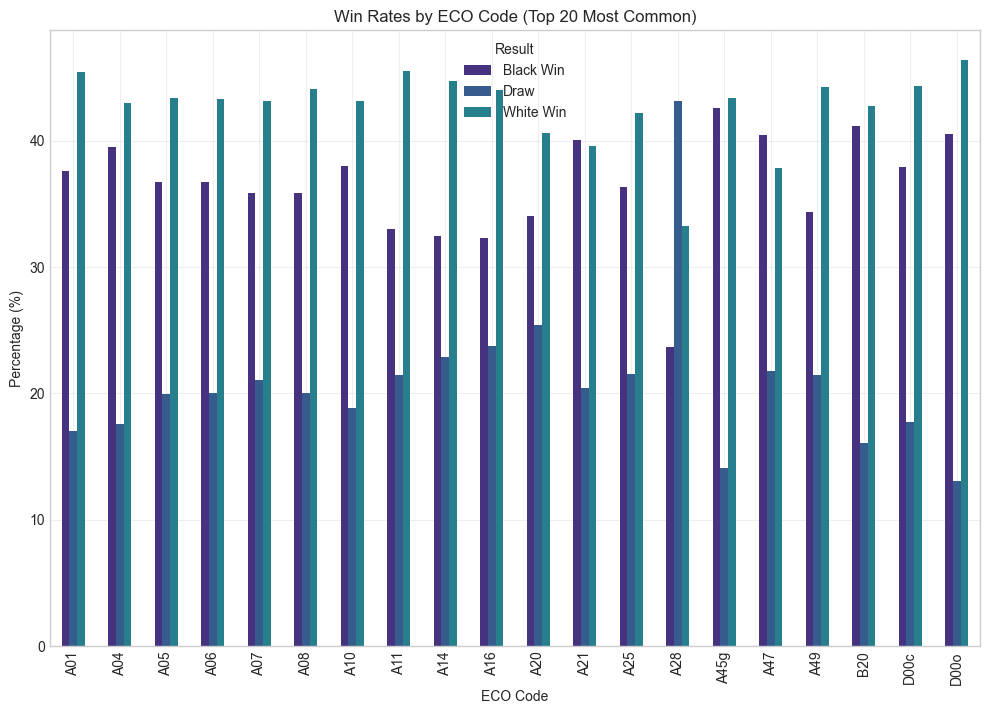

In [26]:
# Analyze win rates by ECO code (top 20 most common ECO codes)
top_eco_codes = chess_df_clean['eco'].value_counts().head(20).index
eco_results = chess_df_clean[chess_df_clean['eco'].isin(top_eco_codes)].groupby('eco')['result_category'].value_counts(normalize=True).unstack() * 100

plt.figure(figsize=(16, 10))
eco_results.plot(kind='bar')
plt.title('Win Rates by ECO Code (Top 20 Most Common)')
plt.xlabel('ECO Code')
plt.ylabel('Percentage (%)')
plt.grid(True, alpha=0.3)
plt.legend(title='Result')
plt.savefig(ANALYSIS_DIR / 'win_rates_by_eco.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.8 Evaluation Analysis (if available)

If the dataset contains engine evaluation data, we can analyze it.

In [27]:
# Check if evaluation info is available
if 'eval_info' in chess_df_clean.columns and chess_df_clean['has_eval_info'].sum() > 0:
    print(f"Dataset contains evaluation information for {chess_df_clean['has_eval_info'].sum():,} games")
    
    # Sample a few games with evaluation info
    sample_evals = chess_df_clean[chess_df_clean['has_eval_info']].sample(min(5, chess_df_clean['has_eval_info'].sum()))
    
    for i, (_, game) in enumerate(sample_evals.iterrows()):
        print(f"\nSample Game {i+1}:")
        print(f"  White: {game['white']} ({game['white_elo']}) vs Black: {game['black']} ({game['black_elo']})")
        print(f"  Result: {game['result']}")
        print(f"  Evaluation Info (first few): {game['eval_info'][:100]}...")
else:
    print("No evaluation information available in the dataset")

Dataset contains evaluation information for 38,759 games

Sample Game 1:
  White: Maddikonda, Ayush (1862.0) vs Black: Shukla, Aniket (2049.0)
  Result: 1/2-1/2
  Evaluation Info (first few): ["0.14","0.34","0.25","0.39","0.31","0.23","0.3","0.22","\n0.37","0.09","\n0.24","0.35","\n0.26","0....

Sample Game 2:
  White: Alvarez Pedraza, Aramis (2452.0) vs Black: Oro, Faustino (2351.0)
  Result: 1/2-1/2
  Evaluation Info (first few): ["0.16","0.24","0.2","0.29","0.08","0.18","0.18","0.25","\n0.28","0.06","\n0.11","-0.05","0.02","0.0...

Sample Game 3:
  White: Yan, Tianqi (2276.0) vs Black: Zhai, Mo (2348.0)
  Result: 1/2-1/2
  Evaluation Info (first few): ["0.14","0.21","0.19","0.21","0.18","0.19","0.16","0.08","\n0.12","0.2","0.09","0.25","0.18","0.21",...

Sample Game 4:
  White: Goldinov, Daniel (1910.0) vs Black: Martaler, Jewgeni (2198.0)
  Result: 1-0
  Evaluation Info (first few): ["0.17","0.49","0.2","0.32","0.25","0.27","0.0","0.25","0.58","0.56","-0.5","0.66","-1.87","-0.79","

### 4.9 Summary Statistics

In [28]:
# Create a summary of the dataset
summary = {
    "Total Games": len(chess_df_clean),
    "Unique Players": len(set(chess_df_clean['white'].tolist() + chess_df_clean['black'].tolist())),
    "Average Elo": chess_df_clean['avg_elo'].mean(),
    "Average Game Length": chess_df_clean['move_count'].mean(),
    "White Win Rate": result_counts.get('White Win', 0) / len(chess_df_clean) * 100,
    "Black Win Rate": result_counts.get('Black Win', 0) / len(chess_df_clean) * 100,
    "Draw Rate": result_counts.get('Draw', 0) / len(chess_df_clean) * 100,
    "Most Common ECO": chess_df_clean['eco'].value_counts().index[0],
    "Games with Evaluation": chess_df_clean['has_eval_info'].sum(),
    "Games with Clock Info": chess_df_clean['has_clock_info'].sum()
}

# Print the summary
print("Dataset Summary:")
for key, value in summary.items():
    if isinstance(value, float):
        print(f"  - {key}: {value:.2f}")
    else:
        print(f"  - {key}: {value:,}")

# Save summary to a JSON file
with open(ANALYSIS_DIR / 'dataset_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

Dataset Summary:
  - Total Games: 12,917,479
  - Unique Players: 391,387
  - Average Elo: 2403.34
  - Average Game Length: 43.84
  - White Win Rate: 41.96
  - Black Win Rate: 35.59
  - Draw Rate: 22.46


ValueError: Cannot specify ',' with 's'.

## 5. Conclusion

We've performed a comprehensive analysis of the chess games dataset, including:

1. Data loading and cleaning
2. Removal of records with NULL values in critical fields
3. Exploratory data analysis with visualizations
4. Statistical insights about players, games, openings, and ratings

The analysis has revealed valuable insights about:
- Distribution of Elo ratings
- Game outcomes and win rates
- Opening popularity and effectiveness
- Top players and their performance
- Historical trends in chess play

All visualizations have been saved to the analysis directory for future reference.